In [ ]:
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
import os

# ==============================================================================
# 1. CARGA DE CONFIGURAÇÃO
# ==============================================================================

def find_project_root(anchor_file="conf/config.yaml"):
    """
    Sobe os diretórios a partir do notebook atual até encontrar
    a pasta onde 'conf/config.yaml' existe.
    """
    current_path = Path.cwd()
    
    # Tenta no diretório atual e sobe até o raiz do sistema
    for parent in [current_path] + list(current_path.parents):
        potential_config = parent / anchor_file
        if potential_config.exists():
            return parent
            
    raise FileNotFoundError(f"Não foi possível encontrar a raiz do projeto contendo '{anchor_file}'.")

# 1. Definir BASE_DIR (Raiz do Projeto)
try:
    BASE_DIR = find_project_root("conf/config.yaml")
    print(f"📂 Raiz do Projeto encontrada: {BASE_DIR}")
except FileNotFoundError as e:
    # Fallback manual caso a busca automática falhe (ajuste se necessário)
    print("Busca automática falhou. Usando fallback.")
    BASE_DIR = Path("/Users/lucasborges/Downloads/TCC")

# 2. Carregar o YAML da pasta conf
CONFIG_PATH = BASE_DIR / "conf/config.yaml"
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

# ==============================================================================
# 2. ATALHOS E VARIÁVEIS GLOBAIS
# ==============================================================================

# Atalhos dos Dicionários do YAML
# P['raw'] vai virar algo como: /Users/.../TCC/data/raw
P = {k: BASE_DIR / v for k, v in config['paths'].items()} # P de Paths
F = config['files']                                       # F de Files
PM = config['params']                                     # PM de Params

print(f"⚙️ Configuração carregada de: {CONFIG_PATH}")

# ==============================================================================
# 3. PONTE DE VARIÁVEIS
# ==============================================================================

# Caminhos de Arquivos (Apontando para o YAML)
TRAIN_EMB_PATH       = P['processed'] / F['track_embeddings']
NEW_EMB_PATH         = P['processed'] / F['new_track_embeddings']
X_TRAIN_PATH         = P['processed'] / F['train_features']
X_TEST_PATH          = P['processed'] / F['test_features']

# Ajuste conforme onde você salvou o df_tracks_complete (interim ou processed?)
# Se não estiver no YAML, usa o caminho construído:
TRACKS_COMPLETE_PATH = P['interim']   / "df_tracks_complete_v5.parquet"

# Caminhos de Grafos
# Verifica se as chaves existem no yaml, senão usa padrão
MATCHING_MAP_PATH    = P.get('graphs_coarsened', P['graphs_bipartite']) / F['matching_map']
SUPER_EMB_PATH       = P.get('graphs_super', P['graphs_bipartite'])     / F['super_embeddings']

# Parâmetros
SEED                 = PM['seed']

# Configurações Visuais Padrão
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

📂 Raiz do Projeto encontrada: /Users/lucasborges/Downloads/TCC
⚙️ Configuração carregada de: /Users/lucasborges/Downloads/TCC/conf/config.yaml


In [8]:
df_playlists       = pd.read_parquet(P['raw'] / "df_playlists_v0.parquet")
df_tracks          = pd.read_parquet(P['raw'] / "df_tracks_v0.parquet")
df_features        = pd.read_parquet(P['raw'] / "features_checkpoint.parquet")
dim_artists        = pd.read_parquet(P['raw'] / "dim_artists.parquet")
dim_albums         = pd.read_parquet(P['raw'] / "dim_albums.parquet")
df_tracks_complete = pd.read_parquet(P['raw'] / "df_tracks_complete.parquet")

print("Tudo carregado!")

Tudo carregado!


In [9]:
import pandas as pd
import numpy as np
import re
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")

pd.options.mode.copy_on_write = True

## Redundâncias

In [10]:
df_tracks_complete[["track_spotify_id", "track_uri", "reccobeats_id", "spotify_href"]].nunique()

track_spotify_id    679889
track_uri           679889
reccobeats_id       387280
spotify_href        387280
dtype: int64

In [11]:
#Remoção de tracks cujas audio features não foram encontradas na API ReccoBeats
df_tracks_complete_v1 = df_tracks_complete[df_tracks_complete["spotify_href"].notna()]

df_tracks_complete_v1[["track_spotify_id", "track_uri", "reccobeats_id", "spotify_href"]].nunique()

track_spotify_id    387280
track_uri           387280
reccobeats_id       387280
spotify_href        387280
dtype: int64

In [12]:
# Remoção de colunas "iguais"
ids_spotify = ["track_spotify_id", "reccobeats_id", "spotify_href", "artist_spotify_id", "album_spotify_id"]
df_tracks_complete_v1 = df_tracks_complete_v1.drop(ids_spotify, axis=1)

In [13]:
df_tracks_complete_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3691508 entries, 0 to 6685100
Data columns (total 29 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_uri               object 
 1   track_name              object 
 2   artist_uri              object 
 3   artist_name             object 
 4   album_uri               object 
 5   album_name              object 
 6   duration_ms             int64  
 7   pos                     int64  
 8   pid                     int64  
 9   acousticness            float32
 10  danceability            float32
 11  energy                  float32
 12  instrumentalness        float32
 13  liveness                float32
 14  loudness                float32
 15  speechiness             float32
 16  tempo                   float32
 17  valence                 float32
 18  key                     Int8   
 19  mode                    Int8   
 20  artist_followers        Int64  
 21  artist_popularity       Int16  
 22 

In [14]:
# Análise de valores duplicados (verifica se há músicas repetidas na mesma playlist)
duplicates = df_tracks_complete_v1.duplicated(subset=['pid', 'track_uri'], keep=False)

print(f"Total de linhas duplicadas (mesma música na mesma playlist): {duplicates.sum()}")
print(f"Percentual de duplicatas: {(duplicates.sum() / len(df_tracks_complete_v1)) * 100:.2f}%")

# Mostrar algumas duplicatas se existirem
if duplicates.any():
    print("\nExemplo de duplicatas encontradas:")
    display(df_tracks_complete_v1[duplicates].head(10))

Total de linhas duplicadas (mesma música na mesma playlist): 93038
Percentual de duplicatas: 2.52%

Exemplo de duplicatas encontradas:


,track_uri,track_name,artist_uri,artist_name,album_uri,album_name,duration_ms,pos,pid,acousticness,...,mode,artist_followers,artist_popularity,artist_genres,release_date,release_date_precision,album_type,total_tracks,label,album_popularity
31,spotify:track:6GIrIt2M39wEGwjCQjGChX,The Great Escape,spotify:artist:0vWCyXMrrvMlCcepuOJaGI,Boys Like Girls,spotify:album:4WqgusSAgXkrjbXzqdBY68,Boys Like Girls,206520,31,0,0.001660,...,0,1278753,64,"[pop punk, emo]",2007-08-31,day,album,12,Columbia,54
51,spotify:track:6GIrIt2M39wEGwjCQjGChX,The Great Escape,spotify:artist:0vWCyXMrrvMlCcepuOJaGI,Boys Like Girls,spotify:album:4WqgusSAgXkrjbXzqdBY68,Boys Like Girls,206520,51,0,0.001660,...,0,1278753,64,"[pop punk, emo]",2007-08-31,day,album,12,Columbia,54
313,spotify:track:1dzQoRqT5ucxXVaAhTcT0J,Just Dance,spotify:artist:1HY2Jd0NmPuamShAr6KMms,Lady Gaga,spotify:album:1qwlxZTNLe1jq3b0iidlue,The Fame,241933,15,5,0.026400,...,0,41496744,93,"[art pop, pop]",2008-01-01,day,album,15,Streamline/Interscope,80
316,spotify:track:1dzQoRqT5ucxXVaAhTcT0J,Just Dance,spotify:artist:1HY2Jd0NmPuamShAr6KMms,Lady Gaga,spotify:album:1qwlxZTNLe1jq3b0iidlue,The Fame,241933,18,5,0.026400,...,0,41496744,93,"[art pop, pop]",2008-01-01,day,album,15,Streamline/Interscope,80
493,spotify:track:6uvT4Di9ZRBw5cbexZJDts,Highwayman,spotify:artist:5W5bDNCqJ1jbCgTxDD0Cb3,Willie Nelson,spotify:album:3DDUesugWE5mJjTF5HFsRg,Nashville Rebel,182973,0,9,0.541000,...,0,2551744,73,"[outlaw country, classic country, country, tra...",2006-09-26,day,album,92,RLG/Legacy,54
494,spotify:track:6uvT4Di9ZRBw5cbexZJDts,Highwayman,spotify:artist:5W5bDNCqJ1jbCgTxDD0Cb3,Willie Nelson,spotify:album:3DDUesugWE5mJjTF5HFsRg,Nashville Rebel,182973,1,9,0.541000,...,0,2551744,73,"[outlaw country, classic country, country, tra...",2006-09-26,day,album,92,RLG/Legacy,54
648,spotify:track:0oIsNC7YcF48ozlsBacKRY,Don't Let Me Down (feat. Cat Martin),spotify:artist:4kjWnaLfIRcLJ1Dy4Wr6tY,Blackmill,spotify:album:2ayhUoOppwZ5paYiXTRqqa,Miracle,407439,62,11,0.002320,...,0,<NA>,<NA>,None,2011-12-21,day,album,11,Blackmill,48
662,spotify:track:0oIsNC7YcF48ozlsBacKRY,Don't Let Me Down (feat. Cat Martin),spotify:artist:4kjWnaLfIRcLJ1Dy4Wr6tY,Blackmill,spotify:album:2ayhUoOppwZ5paYiXTRqqa,Miracle,407439,76,11,0.002320,...,0,<NA>,<NA>,None,2011-12-21,day,album,11,Blackmill,48
749,spotify:track:0ttHpMs250dpFkCYAnuhnE,Good,spotify:artist:4UuoJfJ9UybJft7a8E6UHX,Better Than Ezra,spotify:album:0c8yj78CBgDsEvq9pzudIS,Deluxe,185093,7,14,0.000372,...,1,459372,53,[],1995-02-28,day,album,13,Elektra Records,52
843,spotify:track:0ttHpMs250dpFkCYAnuhnE,Good,spotify:artist:4UuoJfJ9UybJft7a8E6UHX,Better Than Ezra,spotify:album:0c8yj78CBgDsEvq9pzudIS,Deluxe,185093,101,14,0.000372,...,1,459372,53,[],1995-02-28,day,album,13,Elektra Records,52


In [15]:
# Remover duplicatas mantendo a primeira ocorrência
df_tracks_complete_v2 = df_tracks_complete_v1.drop_duplicates(subset=['pid', 'track_uri'], keep='first')

print(f"DataFrame original: {len(df_tracks_complete_v1)} linhas")
print(f"DataFrame sem duplicatas: {len(df_tracks_complete_v2)} linhas")
print(f"Linhas removidas: {len(df_tracks_complete_v1) - len(df_tracks_complete_v2)}")

DataFrame original: 3691508 linhas
DataFrame sem duplicatas: 3643562 linhas
Linhas removidas: 47946


In [16]:
df_tracks_complete_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643562 entries, 0 to 6685100
Data columns (total 29 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_uri               object 
 1   track_name              object 
 2   artist_uri              object 
 3   artist_name             object 
 4   album_uri               object 
 5   album_name              object 
 6   duration_ms             int64  
 7   pos                     int64  
 8   pid                     int64  
 9   acousticness            float32
 10  danceability            float32
 11  energy                  float32
 12  instrumentalness        float32
 13  liveness                float32
 14  loudness                float32
 15  speechiness             float32
 16  tempo                   float32
 17  valence                 float32
 18  key                     Int8   
 19  mode                    Int8   
 20  artist_followers        Int64  
 21  artist_popularity       Int16  
 22 

### Label

In [17]:
df_tracks_complete_v2[["album_type", "label"]].nunique()

album_type        3
label         48036
dtype: int64

In [18]:
# se tiver listas: ok. se tiver NaN: filtra.
tmp = (df_tracks_complete_v2
       .loc[:, ["label", "artist_genres"]]
       .explode("artist_genres")
       .dropna(subset=["artist_genres"]))

# garantir string
tmp["artist_genres"] = tmp["artist_genres"].astype(str)

# n gêneros únicos por label
n_gen_por_label = tmp.groupby("label")["artist_genres"].nunique()

# resumo
print(n_gen_por_label.describe())

count    27875.000000
mean         3.532377
std          7.647902
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        368.000000
Name: artist_genres, dtype: float64


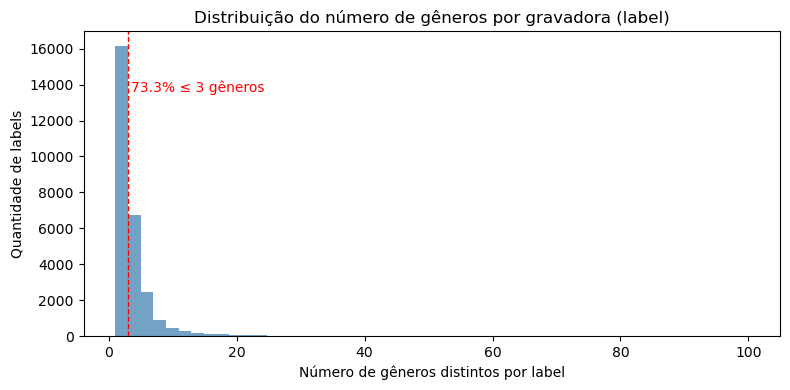

In [20]:
plt.figure(figsize=(8,4))

# remove valores extremos só para visualização (labels com +100 gêneros)
data = n_gen_por_label.clip(upper=100)

sns.histplot(data, bins=50, color="steelblue", edgecolor=None)
plt.title("Distribuição do número de gêneros por gravadora (label)")
plt.xlabel("Número de gêneros distintos por label")
plt.ylabel("Quantidade de labels")

# linha vertical em 3 gêneros
plt.axvline(3, color="red", linestyle="--", lw=1)
plt.text(3.5, plt.ylim()[1]*0.8, "73.3% ≤ 3 gêneros", color="red", fontsize=10)

plt.tight_layout()
plt.show()

In [21]:
df_tracks_complete_v2 = df_tracks_complete_v2.drop(columns=["label"], errors="ignore") #"label" removida 

### Interpretação
- Maioria (≈ 73 %) das gravadoras é especializada, atuando em até três gêneros musicais.
- A minoria (≈ 27 %) cobre centenas de gêneros, correspondendo a grandes selos (majors) com catálogos extremamente diversos.
- Essa combinação gera uma distribuição altamente desigual e esparsa, dificultando o uso da variável como preditor estável.

### Implicações para o modelo
- A presença de milhares de labels raras torna a codificação categórica inviável (47 724 valores distintos).
- O sinal informativo das labels especializadas é diluído pela predominância de grandes gravadoras generalistas.
- Assim, o atributo tende a introduzir ruído e overfitting, sem agregar valor relevante à similaridade musical.

### Conclusão
A variável label foi excluída do conjunto final de features por apresentar alta cardinalidade, baixa consistência semântica e correlação fraca com as dimensões sonoras e de gênero relevantes ao problema de recomendação e cold-start.

In [22]:
df_tracks_complete_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643562 entries, 0 to 6685100
Data columns (total 28 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_uri               object 
 1   track_name              object 
 2   artist_uri              object 
 3   artist_name             object 
 4   album_uri               object 
 5   album_name              object 
 6   duration_ms             int64  
 7   pos                     int64  
 8   pid                     int64  
 9   acousticness            float32
 10  danceability            float32
 11  energy                  float32
 12  instrumentalness        float32
 13  liveness                float32
 14  loudness                float32
 15  speechiness             float32
 16  tempo                   float32
 17  valence                 float32
 18  key                     Int8   
 19  mode                    Int8   
 20  artist_followers        Int64  
 21  artist_popularity       Int16  
 22 

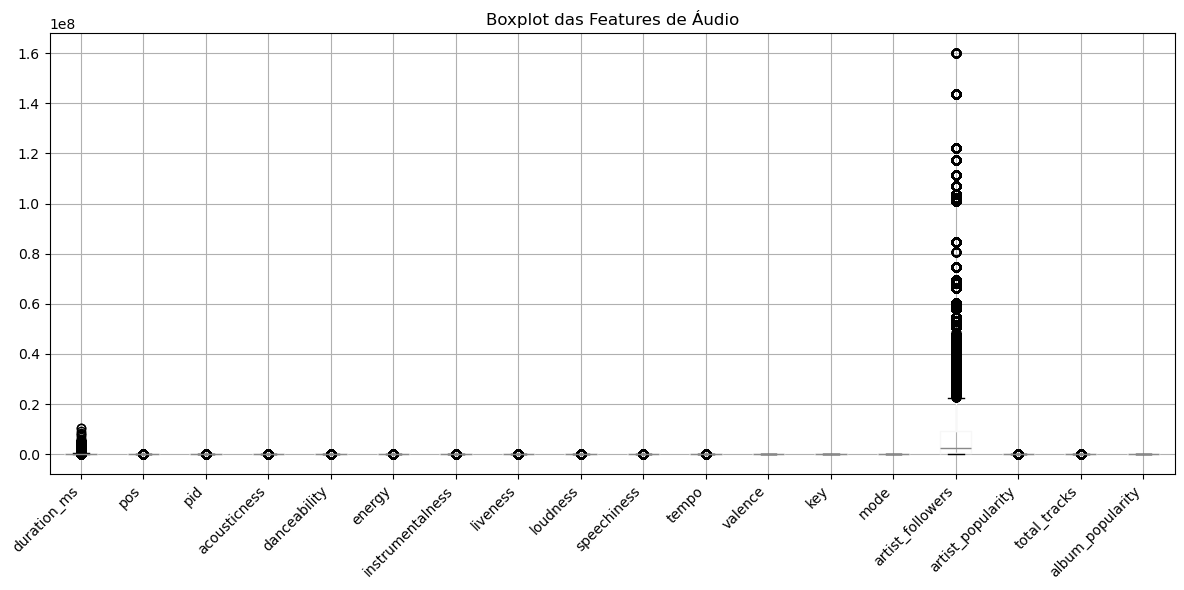

In [23]:
plt.figure(figsize=(12, 6))
df_tracks_complete_v2.boxplot()
plt.title('Boxplot das Features de Áudio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Faltantes

### Conversão numérica

In [24]:
def numeric_conversion(df):
    df_ml = df.copy()
    
    # COLUNAS NUMÉRICAS EXISTENTES → float32
    numeric_to_convert = [
        'duration_ms', 'pos', 'pid', 'acousticness', 'danceability', 
        'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
        'tempo', 'valence', 'key', 'mode', 'artist_followers', 
        'artist_popularity', 'total_tracks', 'album_popularity'
    ]
    
    for col in numeric_to_convert:
        if col in df_ml.columns:
            df_ml[col] = df_ml[col].astype('float32')
    
    # FEATURE ENGINEERING → também em float32
    # Datas
    if 'release_date' in df_ml.columns:
        df_ml['release_date'] = pd.to_datetime(df_ml['release_date'], errors='coerce')
        df_ml['release_year'] = df_ml['release_date'].dt.year.astype('float32')
        df_ml['days_since_release'] = (pd.Timestamp.now() - df_ml['release_date']).dt.days.astype('float32')
    
    return df_ml

In [25]:
# Aplicando 
df_tracks_complete_v3 = numeric_conversion(df_tracks_complete_v2)

In [26]:
df_tracks_complete_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643562 entries, 0 to 6685100
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   track_uri               object        
 1   track_name              object        
 2   artist_uri              object        
 3   artist_name             object        
 4   album_uri               object        
 5   album_name              object        
 6   duration_ms             float32       
 7   pos                     float32       
 8   pid                     float32       
 9   acousticness            float32       
 10  danceability            float32       
 11  energy                  float32       
 12  instrumentalness        float32       
 13  liveness                float32       
 14  loudness                float32       
 15  speechiness             float32       
 16  tempo                   float32       
 17  valence                 float32       
 18  key    

In [28]:
# Salvar usando o caminho dinâmico do YAML
save_path = P['interim'] / "df_tracks_complete_v3.parquet"

df_tracks_complete_v3.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

Salvo em: /Users/lucasborges/Downloads/TCC/data/interim/df_tracks_complete_v3.parquet


In [29]:
del df_tracks_complete, df_tracks_complete_v1, df_tracks_complete_v2
gc.collect()

607

In [30]:
df_tracks_complete_v3.isna().sum()

track_uri                      0
track_name                     0
artist_uri                     0
artist_name                    0
album_uri                      0
album_name                     0
duration_ms                    0
pos                            0
pid                            0
acousticness                 163
danceability                 163
energy                       163
instrumentalness             163
liveness                     163
loudness                     163
speechiness                  163
tempo                        163
valence                      163
key                          163
mode                         163
artist_followers            6829
artist_popularity           6829
artist_genres               6829
release_date              313627
release_date_precision         0
album_type                     0
total_tracks                   0
album_popularity               0
release_year              313627
days_since_release        313627
dtype: int

In [32]:
# Remover linhas com valores faltantes para audio features e artists informations 

cols_remove = [
    "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "loudness", "speechiness", "tempo", "valence",
    "key", "mode",                       # todas com 163 faltantes
    "artist_followers", "artist_popularity", "artist_genres"  # todas com 6829 faltantes
]

df_tracks_complete_v4 = df_tracks_complete_v3.dropna(subset=cols_remove)

In [33]:
# Salvar usando o caminho dinâmico do YAML
save_path = P['interim'] / "df_tracks_complete_v4.parquet"

df_tracks_complete_v4.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

Salvo em: /Users/lucasborges/Downloads/TCC/data/interim/df_tracks_complete_v4.parquet


In [34]:
del df_tracks_complete_v3
gc.collect()

1812

In [35]:
df_tracks_complete_v4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3636571 entries, 0 to 6685100
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   track_uri               object        
 1   track_name              object        
 2   artist_uri              object        
 3   artist_name             object        
 4   album_uri               object        
 5   album_name              object        
 6   duration_ms             float32       
 7   pos                     float32       
 8   pid                     float32       
 9   acousticness            float32       
 10  danceability            float32       
 11  energy                  float32       
 12  instrumentalness        float32       
 13  liveness                float32       
 14  loudness                float32       
 15  speechiness             float32       
 16  tempo                   float32       
 17  valence                 float32       
 18  key    

A remoção das tracks sem audio features e artists informations é embasada pela seguinte análise: 

- após a remoção o grafo (música-playlist) ainda é altamente conectado: o maior componente continua cobrindo ~99% dos nós, mesmo após o corte de quase 45% das músicas;
- o número de componentes conectados foi de 78 para 253, refletindo o surgimento de pequenas ilhas isoladas — componentes de 60 a 200 nós (ver no Top-10 tamanho dos componentes conetados);
- a perda de conectividade global é insignificante (≈0,3%): estatisticamente, o grafo manteve sua estrutura principal intacta;
- o dataset reduziu de 1.3 GB para 765.5 MB;
- a limpeza reduziu quase pela metade o volume de dados e corrigiu outliers, mantendo a conectividade global e a coerência estrutural.
- o grafo “limpo” é estatisticamente equivalente ao original para fins de modelagem, mas muito mais saudável para aprendizado e interpretação.

### Visão Macro

| Métrica           | Original | Limpo v0 | Limpo v1 | Dif. percentual (orig → v1) | Interpretação                                                                                      |
| ----------------- | -------- | -------- | -------- | --------------------------- | -------------------------------------------------------------------------------------------------- |
| **Playlists**     | 100.000  | 99.722   | 99.719   | −0.28 %                     | Quase nenhuma playlist perdida.                                                                    |
| **Músicas**       | 679.889  | 387.280  | 384.722  | −43 %                       | Limpeza removeu quase metade das faixas — esperado se você removeu colunas com nulos e duplicatas. |
| **Arestas (NNZ)** | 6,6 M    | 3,64 M   | 3,63 M   | −45 %                       | Redução proporcional ao número de músicas.                                                         |
| **Densidade**     | 9.70e-5  | 9.43e-5  | 9.48e-5  | ≈ estável                   | Mesmo nível de conectividade relativa entre nós.                                                   |
| **Peso médio**    | 0.1256   | 0.1236   | 0.1236   | −1,6 %                      | Pequeno ajuste, praticamente neutro.                                                               |

### Imputação release_date

In [36]:
def impute_release_info(
    df: pd.DataFrame,
    col_artist: str = "artist_uri",
    ref_ts: pd.Timestamp | None = None,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Imputa release_date, release_year e days_since_release para dados faltantes:
      - Para release_year: média por artista -> mediana global como fallback
      - Para release_date faltante: sintetiza como 1º de julho do ano imputado
      - Recalcula days_since_release a partir da data de referência
      - Mantém dtypes consistentes (float32 para year e days_since_release)
    """
    dfx = df.copy()

    # 0) Preparação inicial
    if ref_ts is None:
        ref_ts = pd.Timestamp.now(tz="UTC").tz_convert(None)  # tz-aware -> naive
    
    # Se ref_ts tiver timezone, remove
    if ref_ts.tz is not None:
        ref_ts = ref_ts.tz_localize(None)

    # Garante que release_date é datetime e tz-naive
    if "release_date" in dfx.columns:
        dfx["release_date"] = pd.to_datetime(dfx["release_date"], errors="coerce")
        # Remove timezone se existir
        if dfx["release_date"].dt.tz is not None:
            dfx["release_date"] = dfx["release_date"].dt.tz_localize(None)
    else:
        dfx["release_date"] = pd.NaT

    # 1) Extrai release_year a partir de release_date (quando disponível)
    has_valid_date = dfx["release_date"].notna()
    
    # Cria ou garante a coluna release_year
    if "release_year" not in dfx.columns:
        dfx["release_year"] = np.nan
    
    # Preenche release_year a partir de release_date válida
    mask_missing_year = dfx["release_year"].isna() & has_valid_date
    if mask_missing_year.any():
        dfx.loc[mask_missing_year, "release_year"] = (
            dfx.loc[mask_missing_year, "release_date"].dt.year.astype("float64")
        )

    # 2) Imputação Hierárquica de release_year
    mask_year_na = dfx["release_year"].isna()
    
    if mask_year_na.any() and verbose:
        print(f"[release impute] Iniciando imputação para {mask_year_na.sum():,} registros sem release_year")

    if mask_year_na.any():
        # PRIMEIRO: Média por artista (quando artista tem outros anos conhecidos)
        if col_artist in dfx.columns:
            # Calcula média de release_year por artista
            artist_means = (
                dfx[dfx["release_year"].notna()]
                .groupby(col_artist)["release_year"]
                .mean()
                .reset_index()
                .rename(columns={"release_year": "artist_mean_year"})
            )
            
            # Faz merge com as médias dos artistas
            dfx = dfx.merge(artist_means, on=col_artist, how="left")
            
            # Preenche com média do artista onde disponível
            mask_artist_fill = mask_year_na & dfx["artist_mean_year"].notna()
            if mask_artist_fill.any():
                dfx.loc[mask_artist_fill, "release_year"] = dfx.loc[mask_artist_fill, "artist_mean_year"]
                if verbose:
                    print(f"[release impute] Preenchidos {mask_artist_fill.sum():,} registros com média por artista")
            
            # Remove coluna auxiliar
            dfx = dfx.drop(columns=["artist_mean_year"])

        # SEGUNDO: Mediana global como fallback final
        mask_still_na = dfx["release_year"].isna()
        if mask_still_na.any():
            global_median = dfx["release_year"].median(skipna=True)
            dfx.loc[mask_still_na, "release_year"] = global_median
            if verbose:
                print(f"[release impute] Preenchidos {mask_still_na.sum():,} registros com mediana global: {global_median:.0f}")

    # 3) Sanidade nos anos e síntese de release_date
    # Limita anos a faixa plausível
    current_year = ref_ts.year
    dfx["release_year"] = dfx["release_year"].clip(lower=1900, upper=current_year)

    # Sintetiza release_date para registros que ainda estão faltando
    mask_missing_date = dfx["release_date"].isna()
    if mask_missing_date.any():
        # Cria datas sintéticas (1º de julho do ano imputado)
        years_to_fill = dfx.loc[mask_missing_date, "release_year"].round().astype("Int64")
        
        def create_synthetic_date(year):
            if pd.isna(year):
                return pd.NaT
            try:
                return pd.Timestamp(year=int(year), month=7, day=1)
            except (ValueError, TypeError):
                return pd.NaT
        
        synthetic_dates = years_to_fill.apply(create_synthetic_date)
        dfx.loc[mask_missing_date, "release_date"] = synthetic_dates
        
        if verbose:
            print(f"[release impute] Sintetizadas {mask_missing_date.sum():,} datas de release")

    # 4) Cálculo de days_since_release 
    if "days_since_release" not in dfx.columns:
        dfx["days_since_release"] = np.nan

    # Garante que ambas as datas são tz-naive para a subtração
    release_dates_naive = dfx["release_date"]
    
    # Calcula dias desde o lançamento (ambos tz-naive agora)
    days_diff = (ref_ts - release_dates_naive).dt.days.astype("float64")
    
    # Garante que não há valores negativos (datas futuras)
    days_diff = np.where(days_diff < 0, 0, days_diff)
    
    # Trata NaNs que possam ter surgido
    days_diff = np.where(np.isnan(days_diff), 0, days_diff)
    
    dfx["days_since_release"] = days_diff

    # Fallback final para qualquer NaN remanescente em days_since_release
    mask_dsr_na = dfx["days_since_release"].isna()
    if mask_dsr_na.any():
        dsr_median = np.nanmedian(dfx["days_since_release"])
        dfx.loc[mask_dsr_na, "days_since_release"] = dsr_median
        if verbose:
            print(f"[release impute] Preenchidos {mask_dsr_na.sum():,} valores de days_since_release com mediana")

    # 5) Ajuste final de tipos
    dfx["release_year"] = dfx["release_year"].astype("float32")
    dfx["days_since_release"] = dfx["days_since_release"].astype("float32")

    # 6) Log final
    if verbose:
        n_na_rd = dfx["release_date"].isna().sum()
        n_na_ry = dfx["release_year"].isna().sum()
        n_na_dsr = dfx["days_since_release"].isna().sum()
        
        print(f"\n[release impute] RESULTADO FINAL:")
        print(f"• release_date faltantes: {n_na_rd:,}")
        print(f"• release_year faltantes: {n_na_ry:,}")
        print(f"• days_since_release faltantes: {n_na_dsr:,}")
        
        # Estatísticas dos anos imputados
        original_with_year = df["release_year"].notna().sum() if "release_year" in df.columns else 0
        imputed_count = len(dfx) - original_with_year
        print(f"• Anos imputados: {imputed_count:,}")

    return dfx

In [38]:
# Aplicar a função 
df_tracks_complete_v5 = impute_release_info(df_tracks_complete_v4, verbose=True)

# Verificar o resultado
print("\nVerificação final:")
print(df_tracks_complete_v5.isna().sum()[['release_date', 'release_year', 'days_since_release']])

[release impute] Iniciando imputação para 313,046 registros sem release_year
[release impute] Preenchidos 167,619 registros com média por artista
[release impute] Preenchidos 299,642 registros com mediana global: 2013
[release impute] Sintetizadas 313,046 datas de release

[release impute] RESULTADO FINAL:
• release_date faltantes: 0
• release_year faltantes: 0
• days_since_release faltantes: 0
• Anos imputados: 313,046

Verificação final:
release_date          0
release_year          0
days_since_release    0
dtype: int64


In [39]:
# Salvar usando o caminho dinâmico do YAML
save_path = P['interim'] / "df_tracks_complete_v5.parquet"

df_tracks_complete_v5.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

Salvo em: /Users/lucasborges/Downloads/TCC/data/interim/df_tracks_complete_v5.parquet


In [40]:
del df_tracks_complete_v4
gc.collect()

27

## Split temporal (treino e teste)

In [41]:
df_tracks_complete_v5.isna().sum()

track_uri                 0
track_name                0
artist_uri                0
artist_name               0
album_uri                 0
album_name                0
duration_ms               0
pos                       0
pid                       0
acousticness              0
danceability              0
energy                    0
instrumentalness          0
liveness                  0
loudness                  0
speechiness               0
tempo                     0
valence                   0
key                       0
mode                      0
artist_followers          0
artist_popularity         0
artist_genres             0
release_date              0
release_date_precision    0
album_type                0
total_tracks              0
album_popularity          0
release_year              0
days_since_release        0
dtype: int64

In [42]:
# Garantir que release_year está em inteiro
df_tracks_complete_v5 = df_tracks_complete_v5.copy()
df_tracks_complete_v5['release_year'] = pd.to_numeric(df_tracks_complete_v5['release_year'], errors='coerce').astype('float32')

# Split temporal
cutoff = 2015
train_df = df_tracks_complete_v5[df_tracks_complete_v5['release_year'] <= cutoff].copy()
test_df  = df_tracks_complete_v5[df_tracks_complete_v5['release_year'] >  cutoff].copy()

print("Tamanho treino:", train_df.shape[0])
print("Tamanho teste:", test_df.shape[0])
print(test_df.shape[0] / train_df.shape[0])

Tamanho treino: 2780846
Tamanho teste: 855725
0.30772110357783206


## Transformação de atributos e Content Embeddings


Audio Features


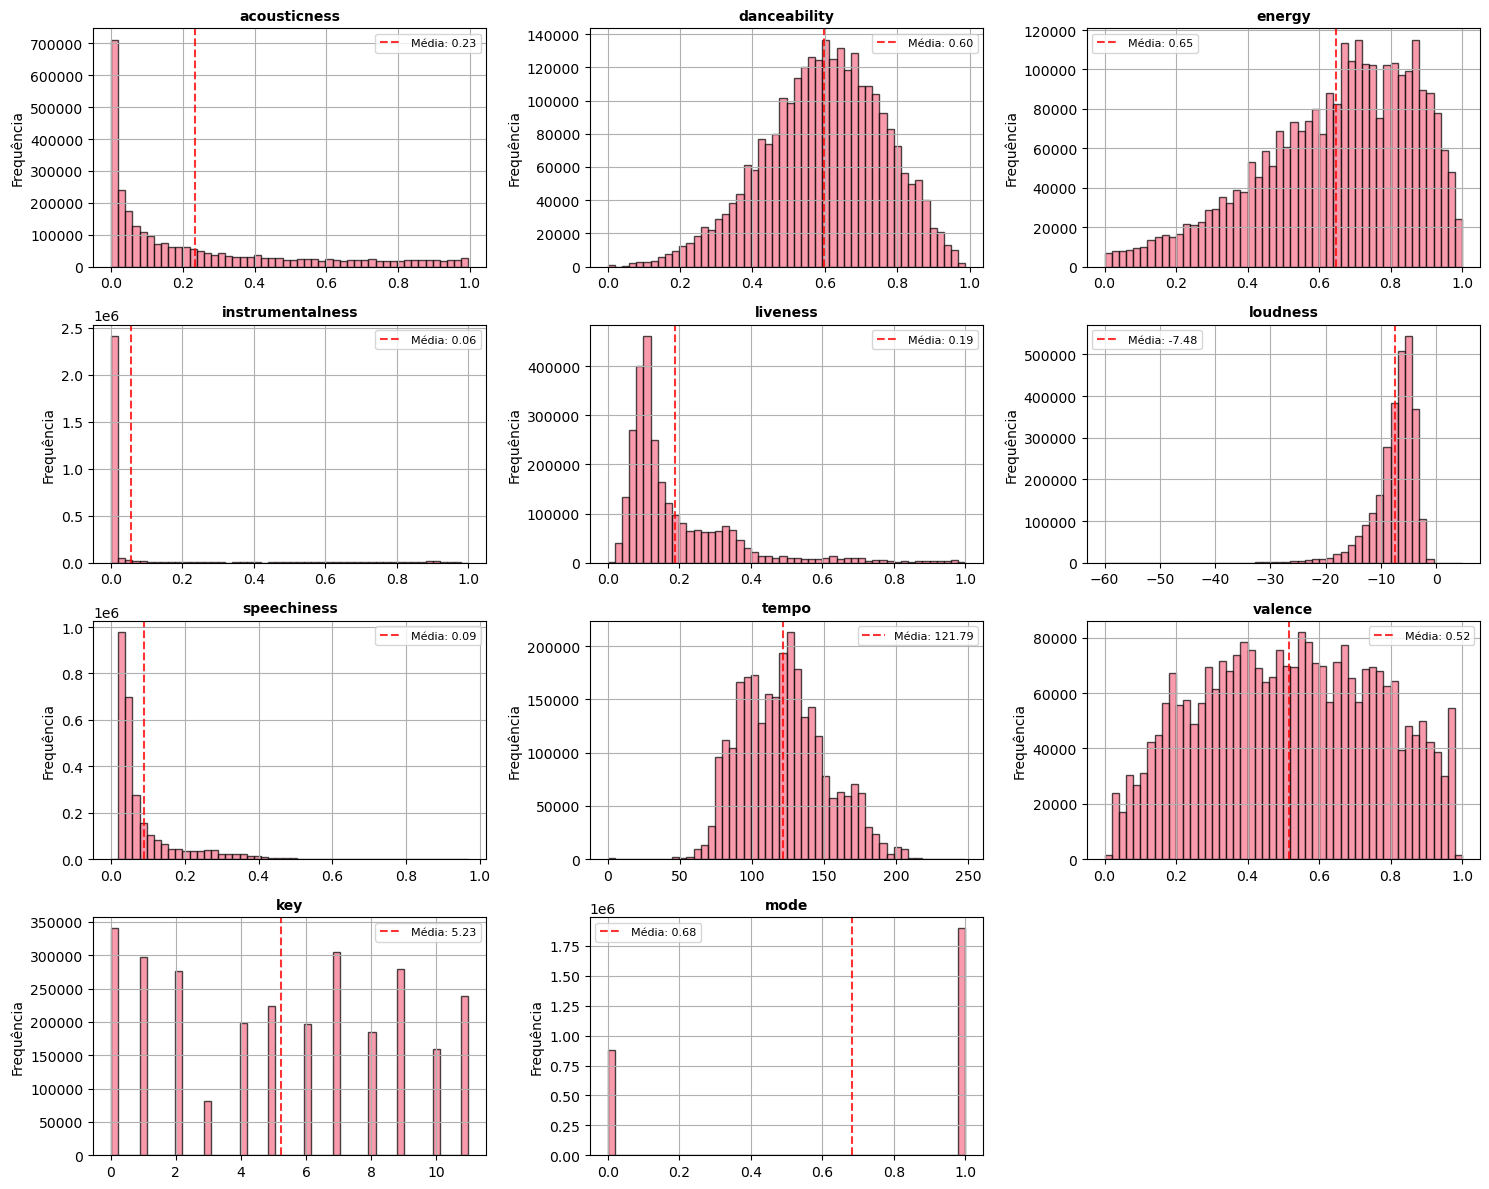

In [43]:
# Colunas por categoria
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode']

popularity_metrics = ['artist_followers', 'artist_popularity', 'album_popularity']

track_metrics = ['duration_ms', 'total_tracks', 'pos', 'pid']

temporal_features = ['release_year', 'days_since_release']


# 1. Audio Features
print("\nAudio Features")
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(audio_features):
    if col in train_df.columns:
        train_df[col].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequência')
        
        # Estatísticas no gráfico
        mean_val = train_df[col].mean()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Média: {mean_val:.2f}')
        axes[i].legend(fontsize=8)

# Ocultar eixos vazios
for i in range(len(audio_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Popularidade


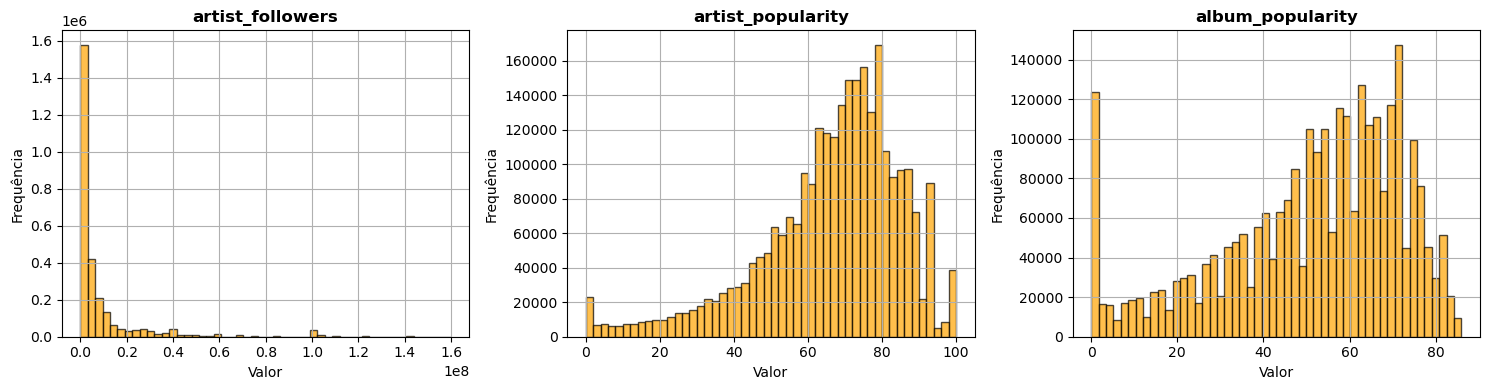

In [45]:
# 2. Métricas de Popularidade
print("Popularidade")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(popularity_metrics):
    if col in train_df.columns:
        train_df[col].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black', color='orange')
        axes[i].set_title(f'{col}', fontweight='bold')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


Tracks


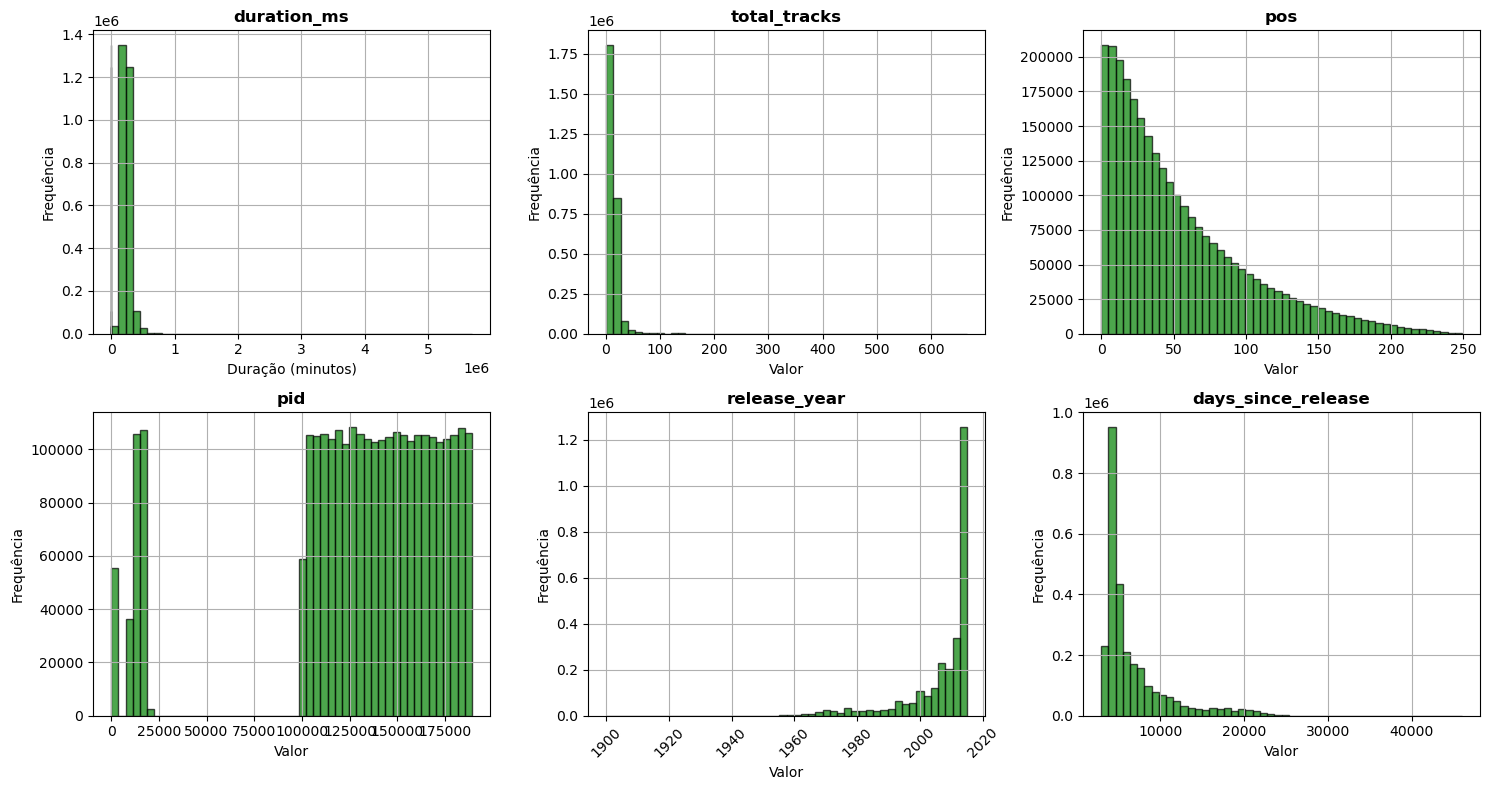

In [46]:
# 3. Métricas temporais
print("\nTracks")
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

all_metrics = track_metrics + temporal_features

for i, col in enumerate(all_metrics):
    if i < len(axes) and col in train_df.columns:
        train_df[col].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black', color='green')
        axes[i].set_title(f'{col}', fontweight='bold')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frequência')
        
        # Ajustes específicos
        if col == 'duration_ms':
            # Converter para minutos para melhor visualização
            (train_df[col] / 60000).hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black', color='green')
            axes[i].set_xlabel('Duração (minutos)')
        elif col == 'release_year':
            axes[i].tick_params(axis='x', rotation=45)

# Ocultar eixos vazios
for i in range(len(all_metrics), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### Artists Genres

In [47]:
# colunas de audio features 
AUDIO_COLS = [
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "loudness", "speechiness", "tempo", "valence", "key", "mode"
]

# colunas de “contexto leve”
CONTEXT_NUM = ["release_year","days_since_release"]
CONTEXT_CAT = ["album_type", "label"]
POP_COLS    = ["artist_popularity"] 

In [49]:
from typing import Optional, Dict, Tuple
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# === HELPERS JÁ EXISTENTES ================================================

def _genres_to_text(xs):
    if isinstance(xs, (list, tuple, np.ndarray)):
        return " ".join(str(x) for x in xs if pd.notna(x))
    elif pd.notna(xs):
        return str(xs)
    else:
        return ""

def _build_artist_genre_embedding(
    artist_df: pd.DataFrame,
    col_genres: str = "artist_genres",
    col_artist: str = "artist_uri",
    n_components: int = 32,
    min_df: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    TF-IDF -> SVD -> Normalizer no nível ARTISTA; 
    retorna df indexado por artist_uri com genre_emb_*
    """
    adf = artist_df[[col_artist, col_genres]].drop_duplicates(col_artist).set_index(col_artist)
    txt = adf[col_genres].fillna("").apply(_genres_to_text)

    tfidf = TfidfVectorizer(min_df=min_df, token_pattern=r"(?u)\b\w[\w+.-]+\b")
    X = tfidf.fit_transform(txt)

    n_comp = min(n_components, max(1, min(X.shape[0], X.shape[1]) - 1))
    svd = TruncatedSVD(n_components=n_comp, random_state=random_state)
    X_red = svd.fit_transform(X)

    norm = Normalizer()
    X_emb = norm.fit_transform(X_red)

    cols = [f"genre_emb_{i:02d}" for i in range(n_comp)]
    return pd.DataFrame(X_emb, index=adf.index, columns=cols).astype("float32")

def _hier_impute_mean(
    df: pd.DataFrame,
    col: str,
    levels=(["artist_uri"], ["album_uri"])
) -> pd.Series:
    """
    Imputa NaN por média hierárquica: artist -> album -> global.
    """
    s = pd.to_numeric(df[col], errors="coerce")
    out = s.copy()
    
    for by in levels:
        m = df.groupby(by, dropna=False)[col].transform("mean")
        nan_mask = out.isna()
        out = out.where(~nan_mask, m)
    
    out = out.fillna(s.mean())
    return out


def build_content_table(
    df_tracks_complete: pd.DataFrame,
    n_genre_components: int = 32,
    min_df_genre: int = 5,
    impute_audio_hier: bool = True,
    album_type2id: Optional[Dict[str, int]] = None,
) -> Tuple[pd.DataFrame, Dict[str, int]]:
    """
    Cria a tabela de conteúdo 1 linha por música com NOMES ORIGINAIS (sem prefixo) + CONTEXTO:
      - Mantém AUDIO_COLS nos nomes originais (incluindo 'tempo' e 'loudness')
      - Mantém 'duration_ms'
      - Mantém POP_COLS (+ 'artist_followers' se existir)
      - CONTEXTO:
          * ctx_release_year (a partir de release_year)
          * ctx_days_since_release (a partir de days_since_release)
          * ctx_album_type_id (a partir de album_type -> IDs)
      - Junta genre_emb_* por artista (TFIDF+SVD+Normalizer)
    Retorna:
      - content: DataFrame track-level para input no pré-processador (S2)
      - album_type2id: mapping categórico -> id (p/ reuso em teste)
    """
    required_min = {"track_uri", "artist_uri", "album_uri", "artist_genres"}
    missing = required_min - set(df_tracks_complete.columns)
    if missing:
        raise ValueError(f"Faltam colunas mínimas: {missing}")

    dfu = df_tracks_complete.drop_duplicates("track_uri").copy()

    # ----------------------------------------------------------------------
    # AUDIO: imputação hierárquica opcional
    # ----------------------------------------------------------------------
    audio_all = list(dict.fromkeys(AUDIO_COLS))  # dedup mantendo a ordem
    if impute_audio_hier:
        for col in audio_all:
            if col in dfu.columns:
                dfu[col] = _hier_impute_mean(dfu, col)

    # ----------------------------------------------------------------------
    # NUMÉRICAS para std: duration_ms, tempo, loudness + contexto temporal
    # ----------------------------------------------------------------------
    # garantir duration_ms numérico
    if "duration_ms" in dfu.columns:
        dfu["duration_ms"] = pd.to_numeric(dfu["duration_ms"], errors="coerce").astype("float32")

    # contexto temporal -> cria colunas ctx_*
    if "release_year" in dfu.columns:
        dfu["ctx_release_year"] = pd.to_numeric(dfu["release_year"], errors="coerce").astype("float32")
    if "days_since_release" in dfu.columns:
        dfu["ctx_days_since_release"] = pd.to_numeric(dfu["days_since_release"], errors="coerce").astype("float32")

    # ----------------------------------------------------------------------
    # POPULARIDADE (robust)
    # ----------------------------------------------------------------------
    pop_cols = POP_COLS.copy()
    if "artist_followers" in dfu.columns and "artist_followers" not in pop_cols:
        pop_cols.append("artist_followers")

    # ----------------------------------------------------------------------
    # CONTEXTO: num e cat leves (além do que já criamos como ctx_*)
    # ----------------------------------------------------------------------
    context_num = [c for c in CONTEXT_NUM if c in dfu.columns and c not in ["release_year", "days_since_release"]]
    context_cat = [c for c in CONTEXT_CAT if c in dfu.columns and c != "album_type"]

    # album_type -> ctx_album_type_id com mapping reutilizável
    if "album_type" in dfu.columns:
        album_type_series = dfu["album_type"].fillna("UNK")

        if album_type2id is not None:
            # reuso do mapping (ex.: em teste)
            default_unk = album_type2id.get("UNK", 0)
            album_type_id = album_type_series.map(lambda x: album_type2id.get(x, default_unk))
            album_type_id = album_type_id.fillna(default_unk).astype("int32")
        else:
            # cria novo mapping (ex.: em treino)
            album_types = sorted(album_type_series.dropna().unique().tolist())
            # garante que UNK exista
            if "UNK" not in album_types:
                album_types = ["UNK"] + album_types
            album_type2id = {cat: i for i, cat in enumerate(album_types)}
            album_type_id = album_type_series.map(album_type2id).astype("int32")

        dfu["ctx_album_type_id"] = album_type_id
        # podemos opcionalmente remover a coluna original
        dfu = dfu.drop(columns=["album_type"], errors="ignore")

    # ----------------------------------------------------------------------
    # GENRE embeddings no nível ARTISTA
    # ----------------------------------------------------------------------
    GEN_artist = _build_artist_genre_embedding(
        dfu[["artist_uri", "artist_genres"]].drop_duplicates("artist_uri"),
        n_components=n_genre_components,
        min_df=min_df_genre
    )
    dfu = dfu.join(GEN_artist, on="artist_uri")

    # ----------------------------------------------------------------------
    # Seleciona / ordena colunas de saída
    # ----------------------------------------------------------------------
    out_cols = []

    # 1) ID
    out_cols.append("track_uri")

    # 2) num p/ std: duration_ms, tempo, loudness, contexto temporal
    for c in ["duration_ms", "tempo", "loudness", "ctx_release_year", "ctx_days_since_release"]:
        if c in dfu.columns:
            out_cols.append(c)

    # 3) áudio restantes (AUDIO_COLS sem tempo/loudness)
    out_cols += [c for c in audio_all if c in dfu.columns and c not in ["tempo", "loudness"]]

    # 4) popularidade/seguidores (robust)
    out_cols += [c for c in pop_cols if c in dfu.columns]

    # 5) contexto leve num/cat (exceto tempo e album_type, já tratados)
    out_cols += context_num
    out_cols += context_cat

    # 6) contexto categórico codificado: ctx_album_type_id
    if "ctx_album_type_id" in dfu.columns:
        out_cols.append("ctx_album_type_id")

    # 7) embeddings de gênero
    out_cols += [c for c in dfu.columns if c.startswith("genre_emb_")]

    # monta tabela final
    content = dfu[out_cols].copy()

    # tipagem: numéricas -> float32; IDs ficam int
    for c in content.columns:
        if c == "track_uri":
            continue
        if c == "ctx_album_type_id":
            content[c] = content[c].astype("int32")
            continue
        if pd.api.types.is_numeric_dtype(content[c]):
            content[c] = pd.to_numeric(content[c], errors="coerce").astype("float32")

    assert content["track_uri"].is_unique, "track_uri deve ser único em content_tbl"
    return content, album_type2id


In [50]:
content_tbl_train, album_type2id = build_content_table(
    train_df,
    n_genre_components=32,
    min_df_genre=5
)

content_tbl_test, _ = build_content_table(
    test_df,
    n_genre_components=32,
    min_df_genre=5,
    album_type2id=album_type2id  # para consistência entre train e test
)

print(content_tbl_train.shape)
print(content_tbl_test.shape)

(327208, 50)
(62891, 50)


In [51]:
track_ids_train = content_tbl_train["track_uri"].reset_index(drop=True)
track_ids_test  = content_tbl_test["track_uri"].reset_index(drop=True)

In [52]:
track_ids_train.shape, track_ids_test.shape

((327208,), (62891,))

### Normalizar

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from joblib import dump

# colunas que queremos padronizar (std) e robust
STD_COLS = ["duration_ms", "tempo", "loudness", "ctx_release_year", "ctx_days_since_release"]
ROB_COLS = ["artist_popularity", "artist_followers"]

pre = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), [c for c in STD_COLS if c in content_tbl_train.columns]),
        ('rob', RobustScaler(quantile_range=(25, 75)), [c for c in ROB_COLS if c in content_tbl_train.columns]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
pre.set_output(transform="pandas")

# treino do pré-processador no TRAIN
pre.fit(content_tbl_train.drop(columns=['track_uri']))

model_path = BASE_DIR / "conf/pre_S2.joblib"

X_train = pre.transform(content_tbl_train.drop(columns=['track_uri'])).reset_index(drop=True)
X_test  = pre.transform(content_tbl_test.drop(columns=['track_uri'])).reset_index(drop=True)

In [55]:
X_train_df = pd.concat([track_ids_train, X_train], axis=1)
X_test_df  = pd.concat([track_ids_test, X_test], axis=1)

In [56]:
X_train_df.shape, X_test_df.shape

((327208, 50), (62891, 50))

In [ ]:
# Salvar usando o caminho dinâmico do YAML
save_path = P['interim'] / "df_tracks_complete_v5.parquet"

df_tracks_complete_v5.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

In [57]:
# Salvar X_train
save_path_train = P['processed'] / F['train_features']
X_train_df.to_parquet(save_path_train, index=False)
print(f"X_train salvo em: {save_path_train}")

# Salvar X_test
save_path_test = P['processed'] / F['test_features']
X_test_df.to_parquet(save_path_test, index=False)
print(f"X_test salvo em: {save_path_test}")

X_train salvo em: /Users/lucasborges/Downloads/TCC/data/processed/X_train.parquet
X_test salvo em: /Users/lucasborges/Downloads/TCC/data/processed/X_test.parquet


In [58]:
track_feats_train = content_tbl_train.copy()
track_feats_test  = content_tbl_test.copy()

In [61]:
# Salvar content_tbl_train
content_tbl_train.to_parquet(P['interim'] / "content_ctx_train.parquet", index=False)

# Salvar content_tbl_test
content_tbl_test.to_parquet(P['interim'] / "content_ctx_test.parquet", index=False)

In [63]:
X_train_df.isna().sum()

track_uri                 0
duration_ms               0
tempo                     0
loudness                  0
ctx_release_year          0
ctx_days_since_release    0
artist_popularity         0
artist_followers          0
acousticness              0
danceability              0
energy                    0
instrumentalness          0
liveness                  0
speechiness               0
valence                   0
key                       0
mode                      0
ctx_album_type_id         0
genre_emb_00              0
genre_emb_01              0
genre_emb_02              0
genre_emb_03              0
genre_emb_04              0
genre_emb_05              0
genre_emb_06              0
genre_emb_07              0
genre_emb_08              0
genre_emb_09              0
genre_emb_10              0
genre_emb_11              0
genre_emb_12              0
genre_emb_13              0
genre_emb_14              0
genre_emb_15              0
genre_emb_16              0
genre_emb_17        